# Weakly supervised semantic segmentation

## Multi stage training
= use several individual models to form a training pipeline

CAM $\implies$ offline pixel-level pseudo-labeling $\implies$ train segmentation model

# Approach
Past methods: Use CLIP to improve CAM for better pseudo-labeling\
**Ours**: CLIP-based single-stave pipeline for WSSS with CLIP used to extract strong semantic features for segmentation prediction

![Screenshot 2024-10-31 alle 11.17.40.png](<attachment:Screenshot 2024-10-31 alle 11.17.40.png>)
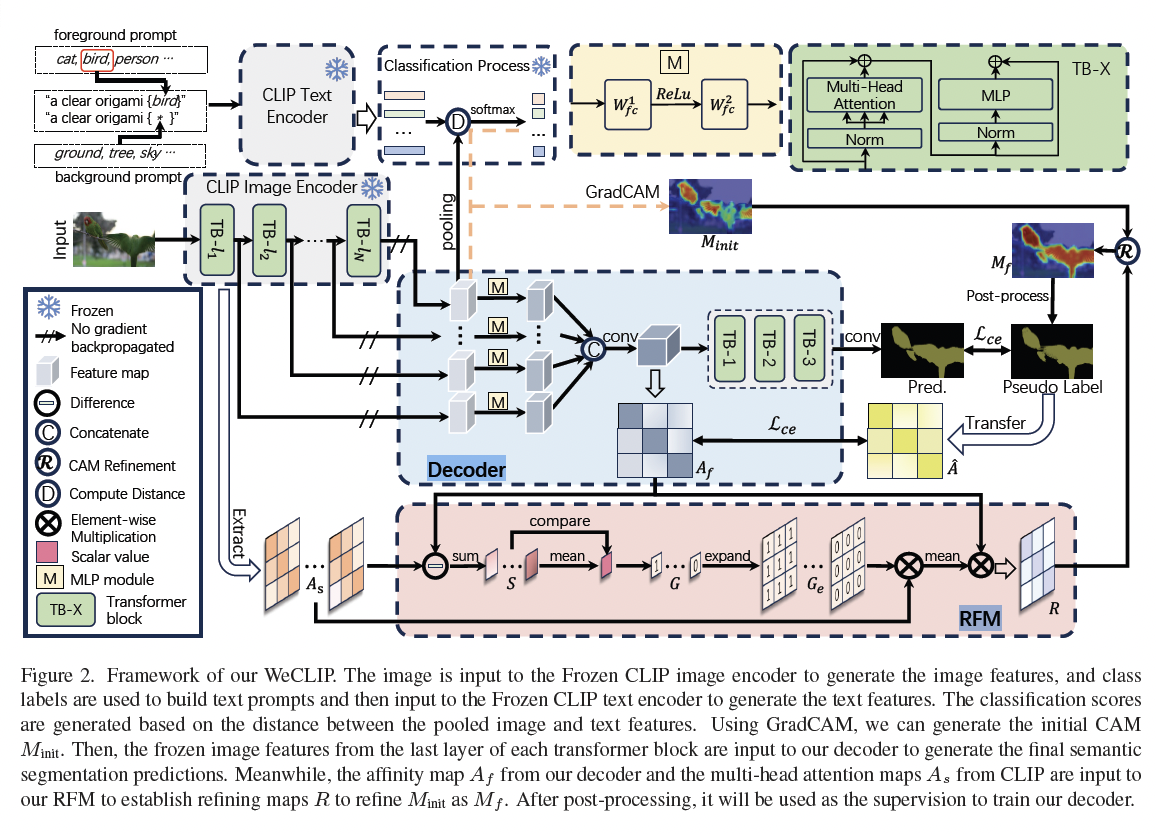

# Methods 

## Overview

Fig.2 shows four main modules:
- a **frozen CLIP backbone** (image encoder and text encoder) to *encode the image and text*, 
- a **classification process** to produce *initial CAM*, 
- a **decoder** to generate *segmentation predictions*, 
- a **RFM** to *refine initial CAM* to provide pseudo labels for training.


The Training pipeline is divided into the following steps:
1. First of all, the **image is input** to the CLIP image encoder for image features. 
    - Besides, the *foreground and background class labels are used to build text prompts* and then input to the CLIP text encoder to *generate the corresponding text features*. 
    - Note here both image and text encoders are **frozen** during training.
2. Then, the classification scores are generated by **computing distances between image features** (after pooling) **and text features**. 
    - Based on classification scores, *Grad-CAM is utilized to generate the initial CAM*.
3. Besides, *image features from the last layer of each transformer block* in the frozen CLIP image encoder are **input to our proposed decoder for the final segmentation predictions**.
4. Simultaneously, the *intermediate feature maps* from our decoder are used to **generate an affinity map**. 
    - Then, the *affinity map is **input to our proposed RFM*** with the *multi-head attention maps* from each block of the frozen CLIP image encoder. 
5. Finally, **RFM outputs a refining map to refine the initial CAM**. 
    - After post-processing, the final converted **pseudo label from refined CAM is used to supervise the training**.



## Frozen CLIP Feature Decoder
Frozen CLIP encoder with ViT-B not optimized during training.

Suppose the input image is $I \in \mathbb R^{3 \times H \times W}$ with $H$ height, $W$ width.

After passing the CLIP image encoder, we get the image feature maps $\{F_{init}^l\}^N_{l=1}$ with $N$ transformer blocks.

Then, for each feature map $F_{init}^l$ an individual MLP module is used to generate new corresponding feature maps $F_{new}^l$:
$$F_{new}^l = W_{fc}^1 (ReLU(W_{fc}^2(F_{init}^l)))$$
where $W_{fc}^1$ and $W_{fc}^2$ are two different fully-connected layers.

After that, all new feature maps $\{F_{new}^l\}^N_{l=1}$ are concatenated together, which are then processed by a convolution layer to generate a fused feature map $F_{u}$:
$$F_u = Conv(Concat[F_{new}^1, F_{new}^2, ..., F_{new}^N])$$
where $F_u \in \mathbb R^{d \times h \times w}$ with $d$ channels, $h$ height, and $w$ width of the feature map. $Conv(\cdot)$ is a convolutional layer, and $Concat[\cdot]$ is the concatenation operation.

Finally, we design several sequential multi-head transformer layers to generate the final prediction $P$:
$$P = Conv(\phi(F_u)) \uparrow$$
where $P \in \mathbb R^{C \times H \times W}$, $C$ is the class number including background,    
$\phi( \cdot )$ represents the sequential multi-head transformer blocks, each block contains:
- a multi-head self-attention module,
- a feed-forward network,
- two normalization layers 

and $\uparrow$ is the upsampling operation to align the prediction map size with the original image.

## Frozen CLIP CAM Refinement
To provide supervision for the prediction P in Eq. (3), we generate the pixel-level pseudo label from the initial CAM of the frozen backbone.

The frozen backbone can only provide static CAM, which means pseudo labels used as supervision cannot be improved during training. The same errors in pseudo labels lead to uncorrectable optimization in the wrong directions. Therefore, we design the Frozen CLIP CAM Refinement module (RFM) to **dynamically update CAM to improve the quality of pseudo labels**.


We first follow [Clip is also an efficient segmenter](https://arxiv.org/abs/2212.09506) to generate the initial CAM.

For the given image $I$ with its class labels, $I$ is input to the CLIP image encoder.\
The class labels are used to build text prompts and input to the CLIP text encoder.

Then, the extracted image features (after pooling) and text features are used to compute the distance and further activated by the softmax function to get the classification scores.

After that, we use GradCAM to generate the initial CAM $M_{init} \in \mathbb R^{(|C_I|+1) \times h \times w}$ where $(|C_I|+1)$ indicates all class labels in the image $I$ including the background class.

To thoroughly utilize the prior knowledge of CLIP, the CLIP model is fixed.\
Although we find that such a frozen backbone can provide strong semantic features for the initial CAM with only image-level labels, as illustrated in Fig. 3(a), $M_{init}$ cannot be optimized as it is generated from the frozen backbone, limiting the quality of pseudo labels.\
Therefore, how to rectify $M_{init}$ during training becomes a key issue.
![Screenshot 2024-10-31 alle 12.05.11.png](<attachment:Screenshot 2024-10-31 alle 12.05.11.png>)

Our intuition is to **use feature relationships to rectify the initial CAM**.\
- However, we cannot directly use the attention maps from the CLIP image encoder as the feature relationship, as such attention maps are also fixed.

Nevertheless, the decoder is constantly being optimized, and we attempt to use its features to establish feature relationships to guide the selection of attention values from the CLIP image encoder, keeping useful prior CLIP knowledge and removing noisy relationships.

With more reliable feature relationships, the CAM quality can be dynamically enhanced.

In detail, we first generate an affinity map based on the feature map $F_u$ in Eq. (2) from our decoder:
$$A_f = \text{Sigmoid}(F_u^T F_u)$$
where:
- $F_u \in \mathbb R^{d \times h \times w}$ is first flattened to $\mathbb R^{d \times hw}$
- Sigmoid(·) is the sigmoid function to guarantee the range of the output is from 0 to 1.
- $A_f \in \mathbb R^{hw \times hw}$ is the affinity map.
- $T$ means matrix transpose.

Then we extract all the multi-head attention mpas from the frozen CLIP image encoder, denoted as $\{A_s^l\}_{l=1}^N$ and each $A_s^l \in \mathbb R^{d \times hw \times ww}$.\
For each $A_s^l$, we use $A_f$ as a standard map to evaluate its quality:
$$S^l = \sum_{i=1}^{hw}\sum_{j=1}^{hw} |A_f(i,j) - A_s^l(i,j)|$$

We use the above $S^l$ to compute a filter for each attention map:
$$
G^l = \begin{cases}
1 & \text{if } S^l < \frac{1}{N - N_0 + 1} \sum_{l = N_0}^N S^l \\
0 & \text{else}
\end{cases}
$$
where $G^l \in \mathbb R^{1 \times 1}$, and it is expanded to $G_e^l \in \mathbb R^{hw \times hw}$ for further computation.

We use the average value of all S^l as the threshold.
- If the current $S^l$ is less than the threshold, it is more reliable, and we set its filter value as 1. 
- Otherwise, we set the filter value as 0. 

Based on this rule, we keep high-quality attention maps and remove weak attention maps.

We then combine $A_f$ and the above operation to build the refining map:
$$R = \frac{A_f}{N_m} \sum_{l=1}^{N} G_e^l A_s^l$$
where $N_m$ is the number of valid $A_s^l$, i.e., $N_m = \sum_{l=N_0}^{N} G^l$

Then, following the previous apporaches, we generate the refined CAM:
$$M_f^c = \left(\frac{R_{nor} + R_{nor}^T}{2}\right)^{\alpha} \cdot M_{init}^c$$
where:
- $c$ is the specified class, 
- $M_f^c$ is the refined CAM for class $c$, 
- $R_{nor}$ is obtained from $R$ using row and column normalization ([Sinkhorn normalization](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-2/A-Relationship-Between-Arbitrary-Positive-Matrices-and-Doubly-Stochastic-Matrices/10.1214/aoms/1177703591.full))
- $\alpha$ is a hyperparameter.

This part passes a box mask indicator to restrict the refining region.

- $M_{init}^c$ is the CAM for class $c$ after reshaping to $\mathbb R^{hw \times 1}$

Finally, $M_f$ is input to the online post-processing module, i.e., pixel adaptive refinement module proposed in [Learning affinity from attention](https://arxiv.org/abs/2203.02664), to generate final online pseudo labels $M_p \in \mathbb R^{h \times w}$.

In this way, our RFM uses the updated feature relationship in our decoder to assess the feature relationship in the frozen backbone to select reliable relationships.\
Then, higher-quality CAM can be generated with the help of more reliable feature relationships for each image. Fig. 3 shows the detailed comparison of generated CAM using different refinement methods.\
Our method generates more accurate responses than the static refinement method proposed in [29] and the initial CAM.

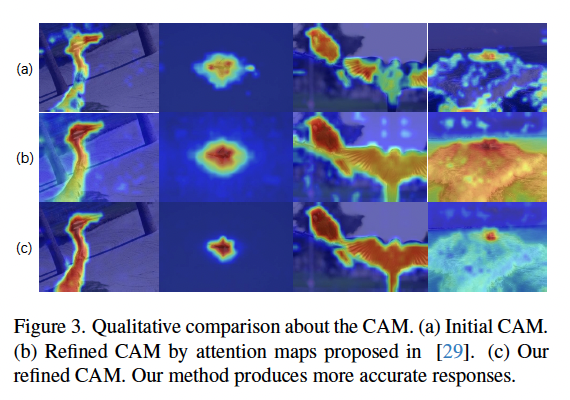

## Loss Function
In our RFM, we use the affinity map $A_f$ to select the attention map and build the final refining map. Therefore, the effectiveness of $A_f$ directly determines the quality of the online pseudo labels. Considering $A_f$ is generated using the feature map $F_u$ in our decoder, and is a learnable module, we propose a learning process for $A_f$ that uses the converted online pseudo label from $M_p$ as supervision.

Specifically, $M_p$ is first converted to the pixel-wise affinity label for each pair of pixels:
$$\hat A = O_h(M_p)^T O_h(M_p)$$
where 
- $O_h(\cdot)$ is one-hot encoding and $O_h(M_p) \in \mathbb R^{C \times hw}$, 
- $\hat A \in \mathbb R^{hw \times hw}$ is the affinity label.
- $\hat A(i,j) = 1$ means pixel $i$ and $j$ has the same label, otherwise, $\hat A(i,j) = 0$

Based on the above label $\hat A$ and the online label $M_p$, the whole loss function of our WeCLIP is: 
$$
\mathcal L = \mathcal L_{ce}(P, M_p, \uparrow) + \lambda \mathcal L_{ce}(A_f, \hat A)
$$
where:
- $\mathcal L_{ce}$ is the cross-entropy loss,
- $M_p \uparrow \in \mathbb R^{H\times W}$
- $\lambda$ is the weighting parameter.
- $P$ is the prediction map generated by the decoder

With this loss, more accurate feature relationships are established for higher-quality pseudo labels.\
In turn, with better pseudo labels, more precise feature relationships are established. Thus, our decoder and RFM can benefit from each other to boost the training.

# Experiment

## Datasets
PASCAL VOC 2012 is appended with SBD [17] to expand the dataset, and the whole dataset contains 10,582 training images, 1,446 validation images, and 1,456 test images with 20 foreground classes.

The MS COCO-2014 dataset includes approximately 82,000 training images and 40,504 validation images with 80 foreground classes.

*Mean Intersection-over-Union (mIoU)* is applied as the evaluation criterion.


## Implementation Details
We use the frozen CLIP backbone with:
- the ViT-16-base architecture [13], 
- N is a fixed number that equals 12. 

For training on the PASCAL VOC 2012 dataset: 
- the batchsize is set as 4,
- the maximum iteration is set as 30000. 

For training on the MS COCO-2014 dataset:
- we set batchsize as 8,
- the maximum iteration as 80000.

We follow CLIP-ES [29] to define the background class set.
- For PASCAL VOC 2012 set, the set is *{ground, land, grass, tree, building, wall, sky, lake, water, river, sea, railway, railroad, keyboard, helmet, cloud, house, mountain, ocean, road, rock, street, valley, bridge, sign}*
- For MS COCO-2014, *{sign, keyboard}* is removed.
- Besides, the text prompt for the background class is *‘a clear origami {background class}’*.

All other settings adopt the same parameters for two datasets during training:
- We use AdamW [32] as the optimizer, 
    - the learning rate is 2e−3 
    - with weight decay 1e−3,
- all images are cropped to 320 × 320 during training. 
- λ in Eq. (10) is set as 0.1, 

- The dimension of the MLP module (Eq. (1)) in our decoder is set as 256. 
- In $\phi$ of Eq. (3), three transformer encoder (the multi-head number is 8) layers are cascaded to generate the final feature map, 
    - each layer’s output dimension is 256. 
- $N_0$ in Eq. (6) is set as 6. 
- $\alpha$ is set as 2 in Eq. (8) following [29].

During inference, we use the multi-scale with $\{0.75, 1.0\}$. Following previous approaches [39, 40, 53], *DenseCRF* [21] is used as the post-processing method to refine the prediction.

## Initial CAM Generation

For a given image $I$ with class label set $C_I$, the image is input to the frozen CLIP image encoder to generate the image feature map as $F \in \mathbb R^{d \times (hw)$, after passing global average pooling, the feature vector $F_v \in \mathbb R \times 1$ is generated.

Meanwhile, the class labels set $C_I$, with the pre-defined background label set $C_{bg}$, are used to build text prompts using the text "a clear origami {*}", where * is the specific class label.

Then the text prompts are iput to the text encoder togenerate the feature map $F_t \in \mathbb R^{d \times (|C_I| + |C_{bg}|)}$.

Using $F_v$ and $F_t$, the distance is compute as:
$$
D = \frac{F_t F_v^T}{||F_t|| \cdot ||F_v||}
$$

Then, the distance is passed to the softmax function to generate the class scores:
$$
S^c = \text{Sotfmax}(D / \tau)
$$
where $S^c$ is the classifcation score for class $c$, and $c \in \{C_{bg}, C_I\}$, $\tau$ is the temperature parameter.

Using GradCAM, we can generate the feature weight map for a specific class $c$ in the $k$th channel:
$$
w_c^k = \frac{1}{hw} \sum_{i=1}^h \sum_{j=1}^w \sum_{c'} \frac{\partial S^c}{\partial D^{c'}} \frac{\partial D^{c'}}{\partial F^{k}_{i,j}}
$$
where $c \in \{C_{bg}, C_I\}$ and $c' \in \{C_{bg}, C_I\}$

Finally, the initial CAM for the specific foreground class $c$ is computed as:
$$
M_{init}^c(i,j) = \text{ReLU}\left(\sum_{k=1}^d w_c^k F_{i, j}^k\right)
$$